In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, n_informative=10, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# Define the logistic regression model
class LogisticRegressionOvR(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionOvR, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)

# Initialize the model
input_dim = X_train.shape[1]
num_classes = len(torch.unique(y_train))
model = LogisticRegressionOvR(input_dim, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

/home/alibina/miniconda3/envs/fastai/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [100/1000], Loss: 0.9528
Epoch [200/1000], Loss: 0.8584
Epoch [300/1000], Loss: 0.8058
Epoch [400/1000], Loss: 0.7733
Epoch [500/1000], Loss: 0.7516
Epoch [600/1000], Loss: 0.7362
Epoch [700/1000], Loss: 0.7248
Epoch [800/1000], Loss: 0.7160
Epoch [900/1000], Loss: 0.7090
Epoch [1000/1000], Loss: 0.7034
Accuracy: 73.50%


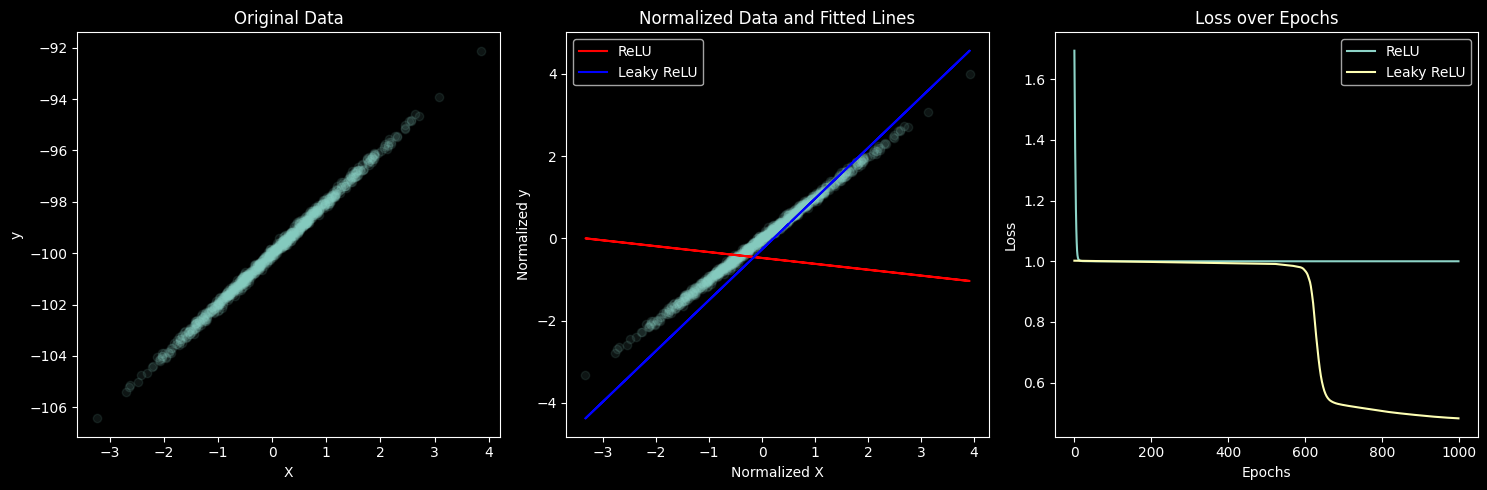

Final loss (ReLU): 1.0
Final loss (Leaky ReLU): 0.48244816542577323
Weights (ReLU): [-0.14289232]
Bias (ReLU): [-0.47637775]
Weights (Leaky ReLU): [1.23299503]
Bias (Leaky ReLU): [-0.26751921]

Predictions vs True Values:
X	ReLU	Leaky ReLU	True
-3.0	-100.54	-103.43		-106.00
0.0	-100.89	-100.48		-100.00
3.0	-101.23	-97.52		-94.00


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def normalize(X):
    return (X - np.mean(X)) / np.std(X)

def train_perceptron(X, y, activation_func, learning_rate=0.1, epochs=1000):
    input_size = X.shape[1]
    weights = np.random.randn(input_size, 1)
    bias = np.random.randn(1)
    
    losses = []
    
    # Create a permutation array for shuffling
    permutation = np.arange(X.shape[0])
    
    for _ in range(epochs):
        # Shuffle the data
        np.random.shuffle(permutation)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        
        # Forward pass
        z = np.dot(X_shuffled, weights) + bias
        a = activation_func(z)
        
        # Compute loss
        loss = np.mean((a - y_shuffled) ** 2)
        losses.append(loss)
        
        # Backward pass
        if activation_func == relu:
            dz = np.where(z > 0, 1, 0) * (a - y_shuffled)
        else:  # leaky_relu
            dz = np.where(z > 0, 1, 0.01) * (a - y_shuffled)
        
        dw = np.dot(X_shuffled.T, dz) / len(y)
        db = np.mean(dz)
        
        # Update parameters
        weights -= learning_rate * dw
        bias -= learning_rate * db
    
    return weights, bias, losses

# Generate some sample data
np.random.seed(42)
X = np.random.randn(1000, 1)
y = 2 * X - 100 + np.random.randn(1000, 1) * 0.1

# Normalize the data
X_norm = normalize(X)
y_norm = normalize(y)

# Train with ReLU
weights_relu, bias_relu, losses_relu = train_perceptron(X_norm, y_norm, relu)

# Train with Leaky ReLU
weights_leaky, bias_leaky, losses_leaky = train_perceptron(X_norm, y_norm, leaky_relu)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X, y, alpha=0.1)
plt.title('Original Data')
plt.xlabel('X')
plt.ylabel('y')

plt.subplot(1, 3, 2)
plt.scatter(X_norm, y_norm, alpha=0.1)
plt.plot(X_norm, X_norm * weights_relu + bias_relu, color='red', label='ReLU')
plt.plot(X_norm, X_norm * weights_leaky + bias_leaky, color='blue', label='Leaky ReLU')
plt.legend()
plt.title('Normalized Data and Fitted Lines')
plt.xlabel('Normalized X')
plt.ylabel('Normalized y')

plt.subplot(1, 3, 3)
plt.plot(losses_relu, label='ReLU')
plt.plot(losses_leaky, label='Leaky ReLU')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print("Final loss (ReLU):", losses_relu[-1])
print("Final loss (Leaky ReLU):", losses_leaky[-1])
print("Weights (ReLU):", weights_relu.flatten())
print("Bias (ReLU):", bias_relu.flatten())
print("Weights (Leaky ReLU):", weights_leaky.flatten())
print("Bias (Leaky ReLU):", bias_leaky.flatten())

# Denormalize the predictions for comparison
def denormalize(X_norm, X_original):
    return X_norm * np.std(X_original) + np.mean(X_original)

X_test = np.array([[-3], [0], [3]])
X_test_norm = normalize(X_test)

y_pred_relu = denormalize(X_test_norm * weights_relu + bias_relu, y)
y_pred_leaky = denormalize(X_test_norm * weights_leaky + bias_leaky, y)
y_true = 2 * X_test - 100

print("\nPredictions vs True Values:")
print("X\tReLU\tLeaky ReLU\tTrue")
for x, relu, leaky, true in zip(X_test, y_pred_relu, y_pred_leaky, y_true):
    print(f"{x[0]:.1f}\t{relu[0]:.2f}\t{leaky[0]:.2f}\t\t{true[0]:.2f}")

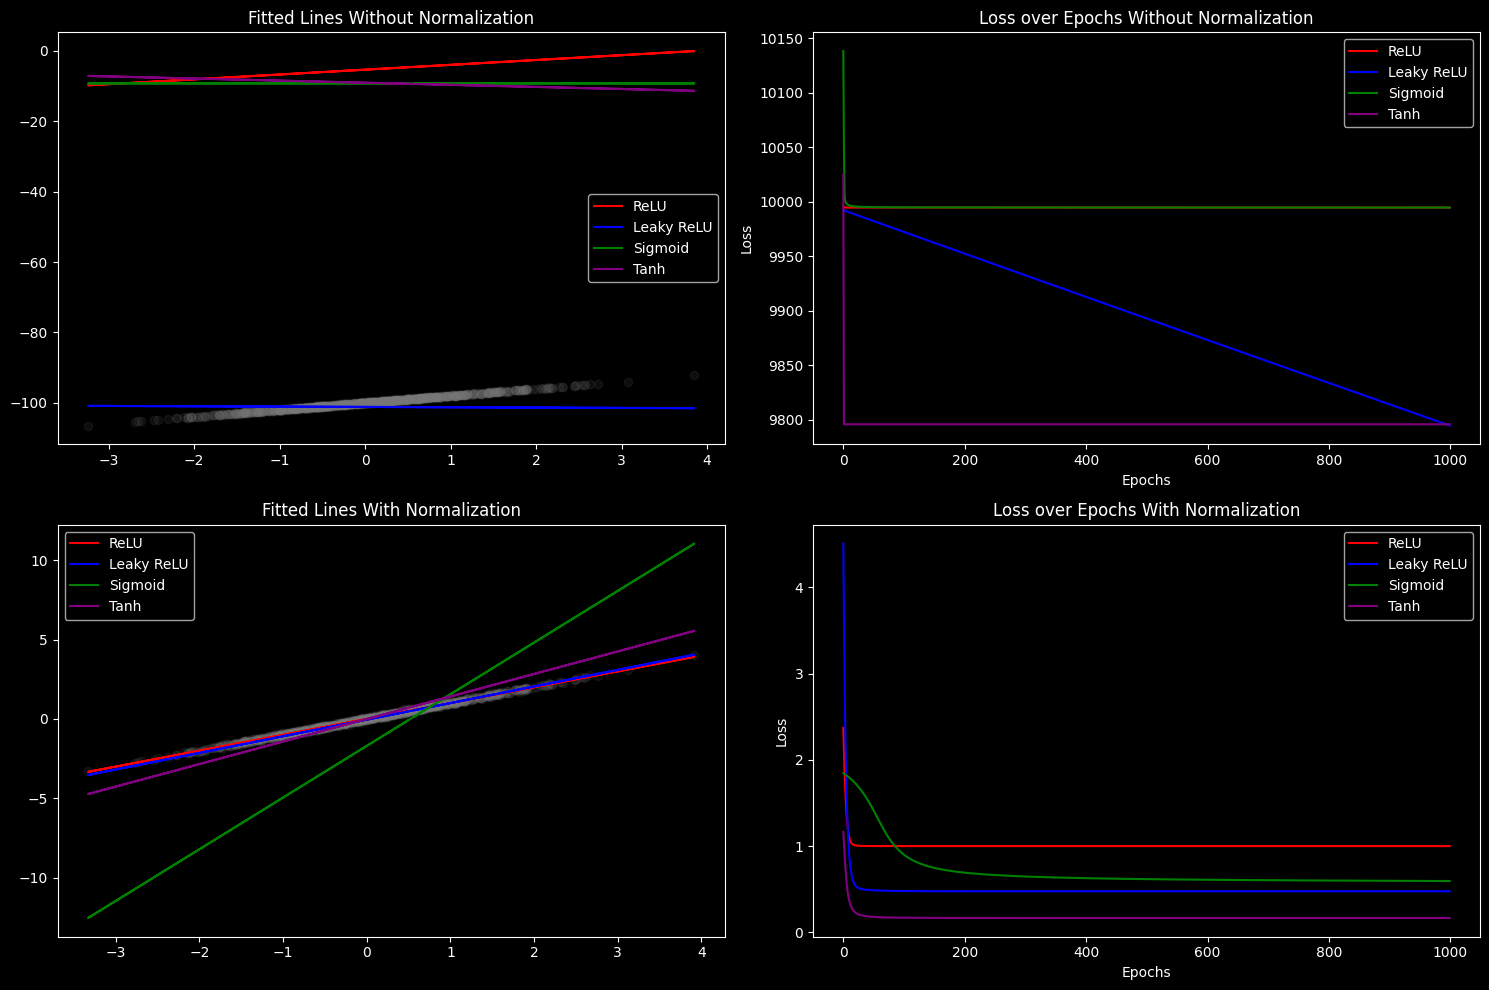

Results with normalized data:
ReLU:
  Final loss: 1.000000
  Weights: -0.062906
  Bias: -0.212637
Leaky ReLU:
  Final loss: 0.476225
  Weights: 1.044406
  Bias: -0.046105
Sigmoid:
  Final loss: 0.593146
  Weights: 3.195259
  Bias: -1.644918
Tanh:
  Final loss: 0.166255
  Weights: 1.419227
  Bias: -0.006383


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def normalize(X):
    return (X - np.mean(X)) / np.std(X)

def train_perceptron(X, y, activation_func, learning_rate=0.01, epochs=1000):
    input_size = X.shape[1]
    weights = np.random.randn(input_size, 1)
    bias = np.random.randn(1)
    
    losses = []
    
    permutation = np.arange(X.shape[0])
    
    for _ in range(epochs):
        np.random.shuffle(permutation)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        
        z = np.dot(X_shuffled, weights) + bias
        a = activation_func(z)
        
        loss = np.mean((a - y_shuffled) ** 2)
        losses.append(loss)
        
        if activation_func == relu:
            dz = np.where(z > 0, 1, 0) * (a - y_shuffled)
        elif activation_func == leaky_relu:
            dz = np.where(z > 0, 1, 0.01) * (a - y_shuffled)
        elif activation_func == sigmoid:
            dz = a * (1 - a) * (a - y_shuffled)
        elif activation_func == tanh:
            dz = (1 - a**2) * (a - y_shuffled)
        
        dw = np.dot(X_shuffled.T, dz) / len(y)
        db = np.mean(dz)
        
        weights -= learning_rate * dw
        bias -= learning_rate * db
    
    return weights, bias, losses

# Generate sample data
np.random.seed(42)
X = np.random.randn(1000, 1)
y = 2 * X - 100 + np.random.randn(1000, 1) * 0.1

# Normalize the data
X_norm = normalize(X)
y_norm = normalize(y)

activation_functions = [relu, leaky_relu, sigmoid, tanh]
colors = ['red', 'blue', 'green', 'purple']
names = ['ReLU', 'Leaky ReLU', 'Sigmoid', 'Tanh']

plt.figure(figsize=(15, 10))

# Train and plot for both normalized and non-normalized data
for i, (data_X, data_y, title) in enumerate([
    (X, y, 'Without Normalization'),
    (X_norm, y_norm, 'With Normalization')
]):
    plt.subplot(2, 2, i*2 + 1)
    for af, color, name in zip(activation_functions, colors, names):
        weights, bias, losses = train_perceptron(data_X, data_y, af, learning_rate=0.1)
        plt.plot(data_X, data_X @ weights + bias, color=color, label=name)
    
    plt.scatter(data_X, data_y, alpha=0.1, color='gray')
    plt.legend()
    plt.title(f'Fitted Lines {title}')

    plt.subplot(2, 2, i*2 + 2)
    for af, color, name in zip(activation_functions, colors, names):
        weights, bias, losses = train_perceptron(data_X, data_y, af, learning_rate=0.1)
        plt.plot(losses, color=color, label=name)
    
    plt.legend()
    plt.title(f'Loss over Epochs {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Print final losses and parameters for normalized data
print("Results with normalized data:")
for af, name in zip(activation_functions, names):
    weights, bias, losses = train_perceptron(X_norm, y_norm, af, learning_rate=0.1)
    print(f"{name}:")
    print(f"  Final loss: {losses[-1]:.6f}")
    print(f"  Weights: {weights.flatten()[0]:.6f}")
    print(f"  Bias: {bias.flatten()[0]:.6f}")

Text(0.5, 1.0, 'Activation Functions')

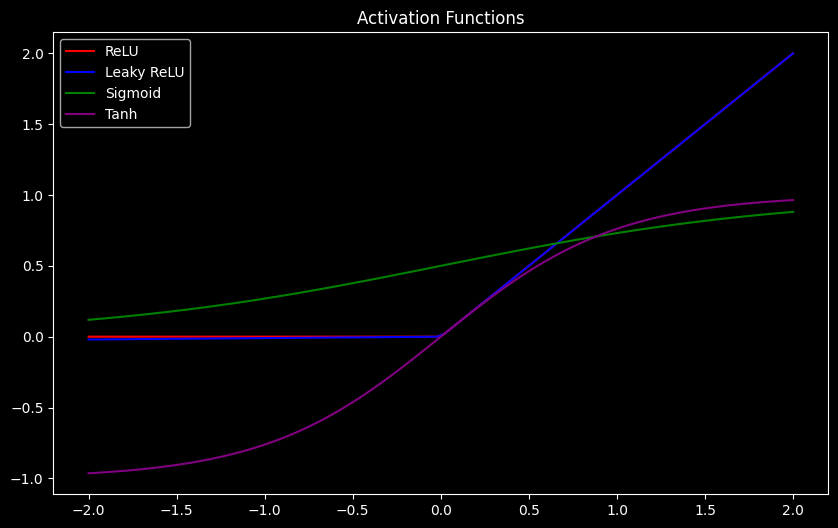

In [30]:
# plot activation functions
x = np.linspace(-2, 2, 100)
plt.figure(figsize=(10, 6))
plt.plot(x, relu(x), label='ReLU', color='red')
plt.plot(x, leaky_relu(x), label='Leaky ReLU', color='blue')
plt.plot(x, sigmoid(x), label='Sigmoid', color='green')
plt.plot(x, tanh(x), label='Tanh', color='purple')
plt.legend()    
plt.title('Activation Functions')

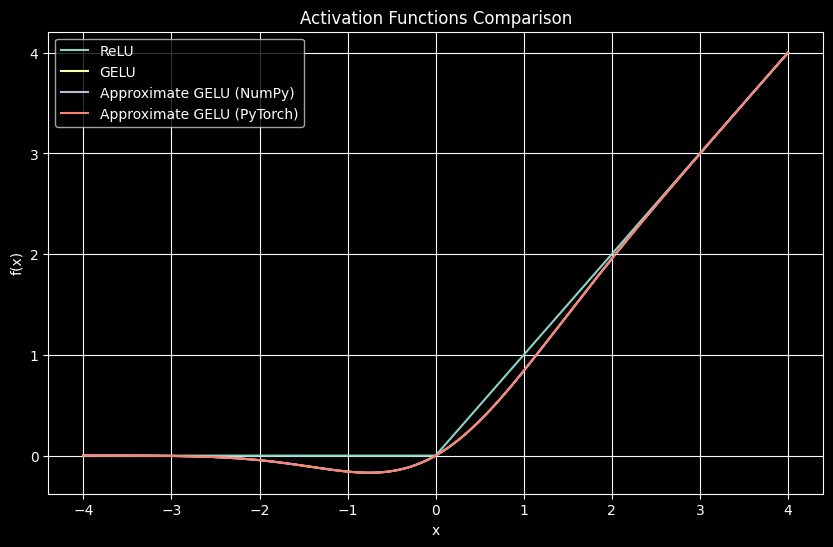

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def gelu_numpy(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * np.power(x, 3))))

def gelu_approximate_numpy(x):
    return 0.5 * x * (1 + np.tanh(0.7978845608028654 * x * (1 + 0.044715 * x * x)))

def gelu_approximate_torch(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return 0.5 * x * (1 + torch.tanh(0.7978845608028654 * x * (1 + 0.044715 * x * x)))

# Generate x values
x = np.linspace(-4, 4, 1000)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, relu(x), label='ReLU')
plt.plot(x, gelu_numpy(x), label='GELU')
plt.plot(x, gelu_approximate_numpy(x), label='Approximate GELU (NumPy)')
# If you need PyTorch version, convert result back to numpy for plotting
plt.plot(x, gelu_approximate_torch(x).numpy(), label='Approximate GELU (PyTorch)')
plt.legend()
plt.grid(True)
plt.title('Activation Functions Comparison')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()